## [Introduction]
This notebook largely consists of the import, cleaning and preprocessing of image datsets collected from different sources. The preprocessing steps include, analyse image aspect ratio, define PyTorch transforms suitable to the dataset, applying the transforms and storing the processed images in the `../data/all_preprocessed_data/` directory.

> **Datasets in use:**
> * Handwritten
> 1. IAM HW
> 2. IAM Online-HW
> 3. IAM Washington

> * Machine Printed
> 1. FUNSD
> 2. SROIE2019 (typewriter-looking font)
> 3. Synthetic data (generated with different fonts and styles using LibreOffice UNO API)

> **Removed:**
> 1. COCO-Text (need to filter usable images strictly, text in the wild is too unorganized)
> 2. CVL-HW (replaced this with UNO API)
> 4. CVIT-HW (the text looks too organized, like printed text, and does not closely represent our data)> 

## Import necessary modules

In [1]:
import os
import json
import re
import sys
import shutil
import csv
import glob

from PIL import Image, UnidentifiedImageError
import torch
from torchvision.transforms import transforms
from torchvision.transforms.functional import affine, adjust_sharpness

%matplotlib inline
import numpy as np
# ! pip install scikit-image
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

from utils import utils
from craft_text_detector import Craft
from tqdm import tqdm

In [ ]:
# Create folders for datasets

# ! mkdir data
# ! mkdir -p data/{IAM,SROIE,MSCOCO,FUNSD}

## Exploring target statistics of width, height and aspect ratios of images

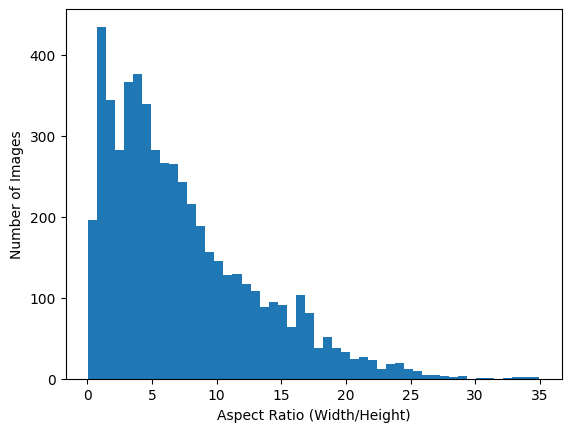

Average aspect ratio: 7.344989132504564
Median aspect ratio: 5.89622641509434


In [100]:
# check aspect ratio of images from CRAFT folder

CRAFT_directory = "/projectnb/sparkgrp/kabilanm/goodfilescraft/"
aspect_ratios = calculate_aspect_ratios(CRAFT_directory)

# Calculate average aspect ratio
average_aspect_ratio = np.mean(aspect_ratios)

# Calculate median aspect ratio
median_aspect_ratio = np.median(aspect_ratios)

# Plot the distribution of aspect ratios
plt.hist(aspect_ratios, bins=50)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Number of Images')
plt.show()

print(f"Average aspect ratio: {average_aspect_ratio}")
print(f"Median aspect ratio: {median_aspect_ratio}")

In [ ]:
# Dive more into aspect ratio and it's distribution

## IAM Dataset

### IAM HW Dataset

In [ ]:
# ! wget --save-cookies data/IAM/cookies.txt \
#  --keep-session-cookies \
#  --post-data 'email=<EMAIL>&password=<PASSWORD>' \
#  --delete-after \
#  https://fki.tic.heia-fr.ch/login

In [ ]:
# ! wget -P data/IAM/ \
#     --load-cookies data/IAM/cookies.txt \
#      https://fki.tic.heia-fr.ch/DBs/iamDB/data/words.tgz
# ! wget -P data/IAM/ \
#     --load-cookies data/IAM/cookies.txt \
#      https://fki.tic.heia-fr.ch/DBs/iamDB/data/lines.tgz
# ! wget -P data/IAM/ \
#     --load-cookies data/IAM/cookies.txt \
#      https://fki.tic.heia-fr.ch/DBs/iamDB/data/sentences.tgz

In [ ]:
# ! mkdir -p data/IAM/{words,sentences,lines}

# ! tar -xzf data/IAM/words.tgz -C data/IAM/words
# ! tar -xzf data/IAM/lines.tgz -C data/IAM/lines
# ! tar -xzf data/IAM/sentences.tgz -C data/IAM/sentences

### Get all image paths

In [68]:
# Util function to collect image paths from subdirectories
def get_image_paths(root_dir, data_levels=None, file_exts=None):
    """
    root_dir (str): Root directory to start from
    data_levels (list): Subdirectories to search for
    file_exts (tuple): File extensions to look for
    """
    
    image_paths = []
    
    if(data_levels == None or file_exts == None):
        # just collect the image paths (no filters)
        for root, _, files in os.walk(os.path.join(root_dir)):
            for file in files:
                if file.endswith(file_exts):
                    image_paths.append(os.path.join(root, file))
        
    else:
        for data_level in data_levels:
            for root, _, files in os.walk(os.path.join(root_dir, data_level)):
                for file in files:
                    if file.endswith(file_exts):
                        image_paths.append(os.path.join(root, file))
                        
    return image_paths

In [72]:
# Get image paths
root_dir = "../data/IAM/"
dataset_levels = ["lines"] # "lines", "sentences", "words"
file_exts = (".png")
img_paths = []

img_paths = get_image_paths(root_dir, dataset_levels, file_exts)

In [77]:
img_paths[0]

'data/IAM/lines/l07/l07-172/l07-172-04.png'

In [73]:
len(img_paths)

128673

In [112]:
# Define the custom conditional transform for IAM images
class IAMTransform:
    
    # Preprocessing pipeline
    transforms_iam_lines = transforms.Compose([
        transforms.Resize([100, ]),
        transforms.FiveCrop((100, 300)),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
    ])

    transforms_iam_words = transforms.Compose([
        transforms.Resize([100, ]),
        transforms.ToTensor()
    ])
    
    def __init__(self, word:bool):
        self.word = word
    
    def __call__(self, image):    
        
        if(self.word == True):
            t = IAMTransform.transforms_iam_words(image)
        else: 
            t = IAMTransform.transforms_iam_lines(image)
    
        return t

In [122]:
output_dir = "../data/all_preprocessed_data/handwritten/"

for img_path in img_paths:
    count = 0
    
    try:
        # Open image
        img = Image.open(img_path)
    except UnidentifiedImageError:
        continue
    
    width, height = img.size
        
    if width < 50 or height < 50:
        continue
        
    # Define conditional
    conditional = True if ("word" in img_path) else False
    
    # Apply transform
    try:
        t = IAMTransform(conditional)(img)
    except ValueError:
        t = IAMTransform(True)(img)
            
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        output_file_path = output_dir + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1

In [132]:
def copy_files(destination_folder, file_path_list):
    for source_path in file_path_list:
        destination_path = os.path.join(destination_folder, source_path.split("/")[-1])
        shutil.copy2(source_path, destination_path)

###  IAM Online HW Dataset

In [ ]:
# ! wget -P data/IAM/ \ 
#     --load-cookies data/cookies.txt \
#     https://fki.tic.heia-fr.ch/DBs/iamOnDB/data/lineImages-all.tar.gz

In [ ]:
# ! tar -xzf data/IAM/lineImages-all.tar.gz -C data/IAM/online/

In [123]:
# Get image paths
root_dir = "../data/IAM/online/"
dataset_levels = ["lineImages"]
file_exts = (".tif")
online_img_paths = []

online_img_paths = get_image_paths(root_dir, dataset_levels, file_exts)

In [124]:
len(online_img_paths)

13017

In [125]:
online_img_paths[0]

'data/IAM/online/lineImages/l07/l07-782/l07-782z-02.tif'

In [129]:
# Define the custom conditional transform for IAM online images
class IAMOnlineTransform:
    
    # Preprocessing pipeline
    transforms_iam_online = transforms.Compose([
        transforms.Resize([100, ]),
        transforms.FiveCrop((100, 300)),
        # returns a 4D tensor of list of cropped images
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])) 
    ])

    def __init__(self):
        pass
    
    def __call__(self, image):
        t = IAMOnlineTransform.transforms_iam_online(image) 
    
        return t

In [132]:
output_dir = "../data/all_preprocessed_data/handwritten/"

for img_path in online_img_paths:
    count = 0
    
    try:
        # Open image
        img = Image.open(img_path)
    except UnidentifiedImageError:
        continue
    
    width, height = img.size
        
    if width < 50 or height < 50:
        continue
    
    # Apply transform
    try:
        t = IAMOnlineTransform()(img)
    except ValueError:
        t = IAMTransform(True)(img)
    
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        output_file_path = output_dir + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1

### Washington Dataset

In [2]:
# ! wget -P data/IAM/ \ 
#     --load-cookies data/cookies.txt \ 
#     https://fki.tic.heia-fr.ch/DBs/iamHistDB/data/washingtondb-v1.0.zip

--2023-06-23 16:04:41--  https://fki.tic.heia-fr.ch/DBs/iamHistDB/data/washingtondb-v1.0.zip
Resolving fki.tic.heia-fr.ch (fki.tic.heia-fr.ch)... 160.98.46.146
Connecting to fki.tic.heia-fr.ch (fki.tic.heia-fr.ch)|160.98.46.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6094716 (5.8M) [application/zip]
Saving to: 'data/IAM/washingtondb-v1.0.zip'

100%[======================================>] 6,094,716   7.94MB/s   in 0.7s   

2023-06-23 16:04:42 (7.94 MB/s) - 'data/IAM/washingtondb-v1.0.zip' saved [6094716/6094716]



In [4]:
# ! unzip -q data/IAM/washingtondb-v1.0.zip -d data/IAM/

In [149]:
# Get image paths
root_dir = "../data/IAM/washingtondb-v1.0/"
dataset_levels = None
file_exts = (".png")
washington_img_paths = []

washington_img_paths = get_image_paths(root_dir, dataset_levels, file_exts)

In [150]:
len(washington_img_paths)

5550

In [151]:
washington_img_paths[0]

'data/IAM/washingtondb-v1.0/data/line_images_normalized/303-04.png'

In [163]:
# All images have a width of 120 pixels.

class IAMWashingtonTransform:
    
    # Define the custom transforms pipeline for line images
    transforms_washington_lines = transforms.Compose([
        transforms.ToTensor(),
#         transforms.GaussianBlur((3, 3), sigma=(0.1, 2.0)),
        transforms.Resize([100, ]),
        transforms.FiveCrop((100, 300)),
        transforms.Lambda(lambda crops: torch.stack([crop for crop in crops]))
    ])
    
    # Define the custom transforms pipeline for word images
    transforms_washington_words = transforms.Compose([
        transforms.ToTensor(),
#         transforms.GaussianBlur((3, 3), sigma=(0.1, 2.0)),
#         transforms.Pad([120, 68, 120, 68]),
        transforms.Resize([100, ]),
    ])
    
    def __init__(self, dim_thresh:tuple):
        self.dim_thresh = dim_thresh
    
    def __call__(self, image):
        width, height = image.size
        
        if(width >= self.dim_thresh[1] and height >= self.dim_thresh[0]):
            t = IAMWashingtonTransform.transforms_washington_lines(image)
        else:
            t = IAMWashingtonTransform.transforms_washington_words(image)
        
        return t

In [164]:
output_dir = "../data/all_preprocessed_data/handwritten/"

for img_path in washington_img_paths:
    count = 0
    
    try:
        # Open image
        img = Image.open(img_path)
    except UnidentifiedImageError:
        continue
    
    width, height = img.size
        
    if width < 50 or height < 50:
        continue
    
    # Apply transform
    try:
        t = IAMWashingtonTransform((120, 600))(img)
    except ValueError:
        t = IAMTransform(True)(img)
    
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        output_file_path = output_dir + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1

## FUNSD

In [ ]:
# ! wget -O data/FUNSD_data.zip https://guillaumejaume.github.io/FUNSD/dataset.zip

In [ ]:
# ! unzip -q data/FUNSD_data.zip -d data/FUNSD

In [37]:
# ! mkdir data/FUNSD/temp

In [40]:
def crop_images_with_bounding_boxes(image_folder, annotation_folder, output_folder):
    
    img_sizes = []
    
    # Iterate over files in the annotations folder
    for annotation_file in os.listdir(annotation_folder):
        annotation_path = os.path.join(annotation_folder, annotation_file)
        
        image_file = os.path.splitext(annotation_file)[0] + ".png"
        image_path = os.path.join(image_folder, image_file)        
        
        # Open the image
        image = Image.open(image_path)
        
        if os.path.isfile(annotation_path):
            # Load bounding box data from JSON file
            with open(annotation_path, 'r') as f:
                raw = json.load(f)
                
                for item in raw["form"]:
                    box = item["box"]
                    label = item["label"]
                    idx = item["id"]
                    
                    if label not in ["other"]:
                        # Crop the image using the bounding box coordinates (the coordinate system is Cartesian)
                        cropped_image = image.crop((box[0], box[1],
                                                    box[2], box[3]))
                        
                        # img_sizes.append(cropped_image.size)
                        
                        # append bounding box id to the cropped image name
                        output_path = os.path.join(output_folder, image_file[:-4]+"-"+str(idx)+".png")
                        # Save the cropped image
                        cropped_image.save(output_path, "PNG")
    # return img_sizes

In [43]:
image_folder = '../data/FUNSD/dataset/training_data/images'
annotation_folder = '../data/FUNSD/dataset/training_data/annotations'
output_folder = '../data/FUNSD/temp'

crop_images_with_bounding_boxes(image_folder, annotation_folder, output_folder)

In [45]:
! ls data/FUNSD/temp | wc -l

6509


In [19]:
len(temp)

6509

In [24]:
np.mean(temp, axis=0)

array([104.99016746,  17.62267629])

In [25]:
np.median(temp, axis=0)

array([75., 15.])

### Looking at the above statistics, resizing the images to a size of (50, x) seems like a good choice. We look to preserve the aspect ratio of the images.

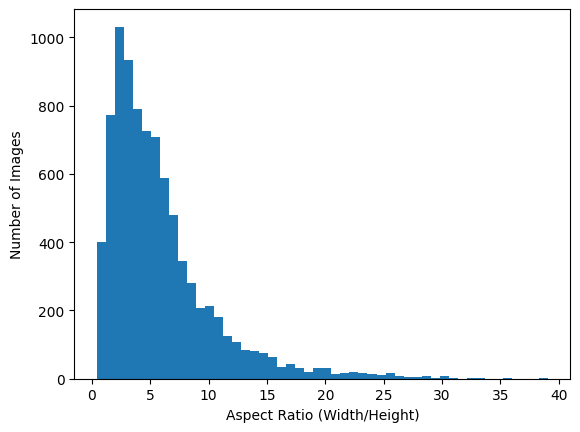

Average aspect ratio: 5.828327605459594
Median aspect ratio: 4.666666666666667


In [96]:
def calculate_aspect_ratios(directory):
    aspect_ratios = []
    for root, _ , files in os.walk(directory):
        for file in files:
            with Image.open(os.path.join(root, file)) as img:
                width, height = img.size
                aspect_ratios.append(width / height)
    return aspect_ratios

directory = '../data/FUNSD/temp'  # Replace with your image directory
aspect_ratios = calculate_aspect_ratios(directory)

# Calculate average aspect ratio
average_aspect_ratio = np.mean(aspect_ratios)

# Calculate median aspect ratio
median_aspect_ratio = np.median(aspect_ratios)

# Plot the distribution of aspect ratios
plt.hist(aspect_ratios, bins=50)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Number of Images')
plt.show()

print(f"Average aspect ratio: {average_aspect_ratio}")
print(f"Median aspect ratio: {median_aspect_ratio}")

In [47]:
image_folder = '../data/FUNSD/dataset/testing_data/images'
annotation_folder = '../data/FUNSD/dataset/testing_data/annotations'
output_folder = '../data/FUNSD/temp'

crop_images_with_bounding_boxes(image_folder, annotation_folder, output_folder)

In [48]:
! ls data/FUNSD/temp | wc -l

8529


{'question': 3266, 'answer': 2802, 'other': 902, 'header': 441} -> unique labels and their counts

In [30]:
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

def view_images(image_paths_list):
    
    num_images = len(image_paths_list)
    image_index = 0
    
    def display_image(image_index):
        image_path = image_paths_list[image_index]
        with open(image_path, 'rb') as file:
            image_widget.value = file.read()
    
    image_widget = widgets.Image(format='png')
    
    # Image navigation buttons
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')
    
    def on_prev_button_clicked(b):
        nonlocal image_index
        image_index = (image_index - 1) % num_images
        display_image(image_index)
    
    def on_next_button_clicked(b):
        nonlocal image_index
        image_index = (image_index + 1) % num_images
        display_image(image_index)
    
    display(image_widget)
    
    # Initial display
    display_image(image_index)
    
    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)
    
    # Display navigation buttons
    display(widgets.HBox([prev_button, next_button]))

In [49]:
funsd_img_paths = []

for file_name in os.listdir("../data/FUNSD/temp"):
    funsd_img_paths.append(os.path.join("../data/FUNSD/temp", file_name))

view_images(funsd_img_paths)

Image(value=b'')

In [64]:
# Transform to preprocess images
class FUNSDTransform:
    
    transforms_FUNSD = transforms.Compose([
        transforms.Resize([50, ]),
        transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2.0)),
        transforms.ToTensor()
    ])
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        
        t = FUNSDTransform.transforms_FUNSD(image)
        
        return t

In [65]:
output_dir = "../data/all_preprocessed_data/typed/"

for img_path in funsd_img_paths:
    count = 0
    
    try:
        # Open image
        img = Image.open(img_path)
    except UnidentifiedImageError:
        continue
    
    width, height = img.size
        
    if width < 50 or height < 50:
        continue
    
    # Apply transform
    try:
        t = FUNSDTransform()(img)
    except ValueError:
        t = IAMTransform(True)(img)
    
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        output_file_path = output_dir + "FUNSD" + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1

In [97]:
! ls data/all_preprocessed_data/typed/ | wc -l

8529


In [67]:
temp_img_paths = []

for file_name in os.listdir("../data/all_preprocessed_data/typed"):
    temp_img_paths.append(os.path.join("../data/all_preprocessed_data/typed", file_name))

view_images(temp_img_paths)

Image(value=b'')

## CVIT-IIIT-HW

In [ ]:
# mkdir CVIT
# cd CVIT
# wget http://ocr.iiit.ac.in/data/dataset/iiit-hws/groundtruth.tar.gz
# wget http://ocr.iiit.ac.in/data/dataset/iiit-hws/iiit-hws.tar.gz

In [ ]:
# tar -xzf data/CVIT/iiit-hws.tar.gz -C data/CVIT/
# tar -xzf data/CVIT/groundtruth.tar.gz -C data/CVIT/

In [ ]:
# ! pip install h5py

In [ ]:
# import scipy.io
# mat = scipy.io.loadmat('')

# import numpy as np
# import h5py

# f = h5py.File('../data/CVIT/groundtruth/groundtruth/IIIT-HWS-10K.mat','r')
# f.keys()

In [ ]:
# ref = f['list']['ALLnames'][0][0]

# data = f['list']['ALLnames']
# data = np.array(f[ref]) # For converting to a NumPy array
# data

In [ ]:
! ls data/CVIT/Images_90K_Normalized/ | wc -l

In [137]:
cvit_folder = "../data/CVIT/Images_90K_Normalized/"
cvit_img_paths = []

In [138]:
cvit_sub_folders = [f for f in os.listdir(cvit_folder)]
len(cvit_sub_folders)

88172

In [139]:
cvit_sub_folders[:10]

['58134',
 '65568',
 '73907',
 '705',
 '74462',
 '34888',
 '70137',
 '34866',
 '74068',
 '21826']

In [140]:
max_num_files = 1000
num_files = 0
break_flag = 0

# Iterate over files in the images folder
for sub_folder in cvit_sub_folders:    
    folder_path = os.path.join(cvit_folder, sub_folder)
    files = os.listdir(folder_path)
        
    for file in files:
        img_path = os.path.join(folder_path, file)
        cvit_img_paths.append(img_path)

        num_files += 1
        if num_files >= max_num_files:
            break_flag = 1
            break  # Break out of the loop if the desired limit is reached
    
    if break_flag == 1:
        break  # Break out of the loop if the desired limit is reached

In [141]:
len(cvit_img_paths)

1000

In [148]:
view_images(cvit_img_paths)

Image(value=b'')

In [149]:
cvit_img_paths[0:10]

['data/CVIT/Images_90K_Normalized/58134/97_5_2_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/596_2_2_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/519_5_1_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/32_2_4_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/288_2_1_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/529_4_4_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/197_2_2_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/566_2_4_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/324_7_1_0_0.png',
 'data/CVIT/Images_90K_Normalized/58134/87_3_3_0_0.png']

### Applying affine transform (to warp images, since they look like machine printed text)

In [ ]:
img = Image.open(cvit_img_paths[1])
img

In [ ]:
img.size

In [ ]:
! pip install python-magic

In [ ]:
t = magic.from_file(cvit_img_paths[0])
t

In [ ]:
re.search('(\d+) x (\d+)', t).groups()

In [ ]:
# Get the smallest and largest image by area (randomly picked)
for img_path in cvit_img_paths:
    

In [ ]:
transformed_img = affine(img, angle=0, translate=(0,0), scale=1.0, shear=(-40, 10), fill=(255))
transformed_img

# RamdomAffine with shear ((-40 to 40), (-10, 10)) and fill=(255)

In [ ]:
# Define the custom conditional transform
class ConditionalTransform:
    def __init__(self, h_threshold, w_threshold):
        self.threshold = threshold
        self.transform1 = transform1
    
    def __call__(self, image):
        width, height = image.size
        
        if width > self.w_threshold and height > self.h_threshold:
            transforms.Resize((256, 500)),
            transforms.CenterCrop((256, 300)),
            return self.transform1(image)
        else:
            return image

In [ ]:
# Define the transforms pipeline
transforms1 = transforms.Compose([
    ConditionalTransform(256, 600),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

## SROIE2019

In [ ]:
# gdown https://drive.google.com/uc?id=1rKcCu6Pi5SB_CbHWnL7Hk2GBwhf1Iz0K

In [ ]:
# ! unzip -q ../data/SROIE2019/SROIE2019.zip

In [72]:
# ! mkdir ../data/SROIE2019/temp

In [69]:
root_dir = "../data/SROIE2019/0325updated.task1train(626p)/"
file_exts = (".jpg")
sroie_img_paths = []

sroie_img_paths = get_image_paths(root_dir, None, file_exts)

In [70]:
len(sroie_img_paths)

712

In [71]:
sroie_img_paths[0]

'data/SROIE2019/0325updated.task1train(626p)/X51007846326.jpg'

In [99]:
#  This took way too long to finish

output_dir = "../data/SROIE2019/temp/"

for img_path in sroie_img_paths:
    
    count = 0
    
    img_id = img_path.split("/")[-1][:-4]
    
    if("(" in img_id):
        continue
    
    annotation_file = root_dir + img_id + ".txt"
    # Open the image
    image = Image.open(img_path)
    
    with open(annotation_file, "r") as ann:
        reader = csv.reader(ann)
        
        for row in reader:
            x1, y1, x2, y2, x3, y3, x4, y4 = tuple([int(x) for x in row[0:8]])
                        
            left = min(x1, x2, x3, x4)
            right = max(x1, x2, x3, x4)
            upper = min(y1, y2, y3, y4)
            lower = max(y1, y2, y3, y4)
                        
            cropped_image = image.crop((left, upper, right, lower))
            output_name = img_id + "-" + str(count)
            
            cropped_image.save(output_dir+output_name+".png", "PNG")
            
            count += 1

In [101]:
temp_img_paths = []

for file_name in os.listdir("../data/SROIE2019/temp"):
    temp_img_paths.append(os.path.join("../data/SROIE2019/temp", file_name))

view_images(temp_img_paths)

Image(value=b'')

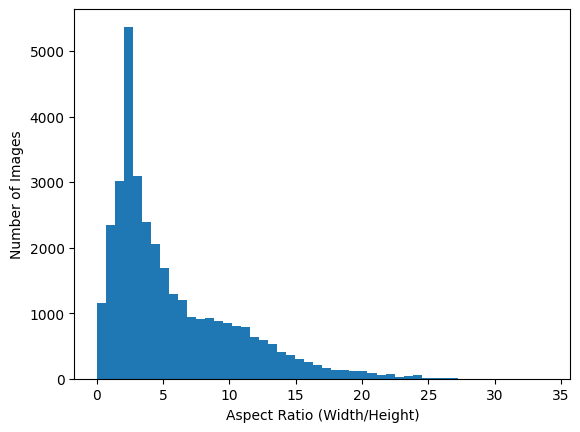

Average aspect ratio: 5.719766256143995
Median aspect ratio: 4.0


In [102]:
directory = '../data/SROIE2019/temp'  # Replace with your image directory
aspect_ratios = calculate_aspect_ratios(directory)

# Calculate average aspect ratio
average_aspect_ratio = np.mean(aspect_ratios)

# Calculate median aspect ratio
median_aspect_ratio = np.median(aspect_ratios)

# Plot the distribution of aspect ratios
plt.hist(aspect_ratios, bins=50)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Number of Images')
plt.show()

print(f"Average aspect ratio: {average_aspect_ratio}")
print(f"Median aspect ratio: {median_aspect_ratio}")

In [118]:
# Define the custom transform
class SROIETransform:
    
    # Define the custom transforms pipeline for longer images
    transforms_sroie_lines = transforms.Compose([
        transforms.ToTensor(),
#         transforms.GaussianBlur((3, 3), sigma=(0.1, 0.1)),
        transforms.Resize([100, ]),
        transforms.FiveCrop((100, 300)),
        transforms.Lambda(lambda crops: torch.stack([crop for crop in crops]))
    ])
    
    # Define the custom transforms pipeline for shorter images
    transforms_sroie_words = transforms.Compose([
        transforms.ToTensor(),
#         transforms.GaussianBlur((3, 3), sigma=(0.1, 0.1)),
        transforms.Resize([100, ]),
    ])
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        width, height = image.size
        aspect_ratio = width/height
        
        if(aspect_ratio >= 5): 
            t = SROIETransform.transforms_sroie_lines(image)
        else:
            t = SROIETransform.transforms_sroie_words(image)
        
        return t

In [119]:
output_dir = "../data/all_preprocessed_data/typed/"
directory = '../data/SROIE2019/temp/'  

for img_path in os.listdir(directory):
    count = 0
    
    try:
        # Open image
        img = Image.open(directory+img_path)
    except UnidentifiedImageError:
        continue
    
    width, height = img.size
        
    if width < 50 or height < 50:
        continue
    
    # Apply transform
    try:
        t = SROIETransform()(img)
    except ValueError:
        t = IAMTransform(True)(img)
    except RuntimeError:
        # to exclude images smaller than the kernel used for blurring.
        continue
    
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        output_file_path = output_dir + "SROIE" + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1

In [120]:
temp_img_paths = []
root_dir = "../data/all_preprocessed_data/typed/"

g = glob.glob(root_dir+"*SROIE*")

count = 0

for file_name in g:
    count += 1
    temp_img_paths.append(file_name)

view_images(temp_img_paths)

Image(value=b'')

## COCO-Text

In [ ]:
# wget http://images.cocodataset.org/zips/train2014.zip
# unzip -q train2014.zip

In [ ]:
! git clone https://github.com/bgshih/coco-text

In [122]:
sys.path.insert(0, '../data/MSCOCO/coco-text/')

import coco_text

In [123]:
ct = coco_text.COCO_Text('../data/MSCOCO/cocotext.v2.json')

loading annotations into memory...
0:00:03.602773
creating index...
index created!


In [124]:
ct.info()

In [125]:
imgs_typed = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('class','machine printed')])
len(imgs_typed)

19039

In [126]:
imgs_hw = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('class','handwritten')])
len(imgs_hw)

5

In [127]:
dataDir='../data/MSCOCO/'
dataType='train2014'

In [128]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [129]:
# pick one at random
img = ct.loadImgs(imgs_typed[np.random.randint(0,len(imgs_typed))])[0]

In [ ]:
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
print('/images/%s/%s'%(dataType,img['file_name']))
plt.figure()
plt.imshow(I)

/images/train2014/COCO_train2014_000000437292.jpg


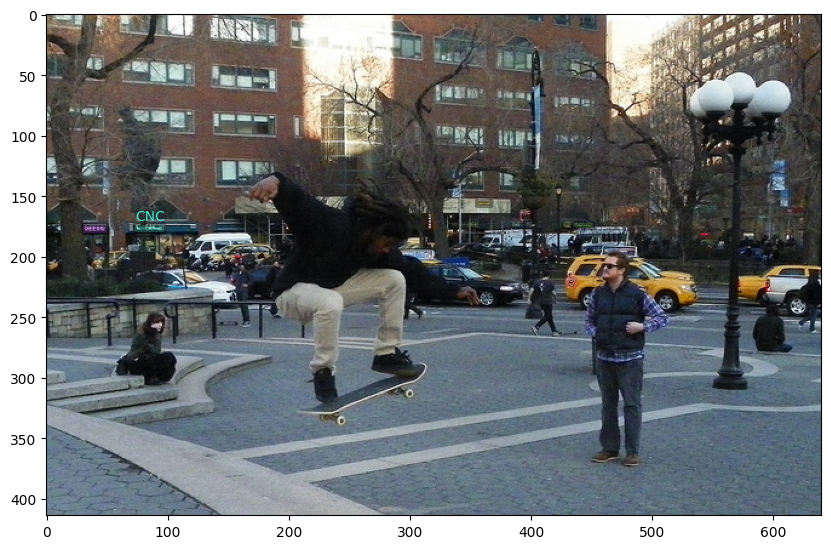

In [134]:
# load and display text annotations
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)

In [135]:
img

{'id': 437292,
 'set': 'train',
 'width': 640,
 'file_name': 'COCO_train2014_000000437292.jpg',
 'height': 414}

In [136]:
annIds

[134468, 134469, 134470, 134471, 134472, 134473]

In [137]:
for ann in anns:
    print(ann['class'], "-> ", ann['bbox'])

machine printed ->  [73.1, 173.6, 23.4, 5.6]
machine printed ->  [355.5, 154.2, 11.2, 4.2]
machine printed ->  [435.9, 172.2, 15.4, 3.9]
machine printed ->  [393.7, 166.0, 6.3, 1.1]
machine printed ->  [395.0, 167.5, 4.8, 1.8]
machine printed ->  [29.9, 173.7, 19.9, 6.5]


In [138]:
ann

{'mask': [29.9, 174.2, 30.3, 179.8, 49.5, 180.2, 49.8, 173.7],
 'class': 'machine printed',
 'bbox': [29.9, 173.7, 19.9, 6.5],
 'image_id': 437292,
 'id': 134473,
 'language': 'english',
 'area': 118.28,
 'utf8_string': '',
 'legibility': 'illegible'}

In [144]:
# Get all images IDs with machine printed text
imgs_typed = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('class','machine printed')])
len(imgs_typed)

19039

In [140]:
# Get all images IDs with machine printed text
imgs_hw = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('class','handwritten')])
len(imgs_hw)

5

In [157]:
def COCO_crop_images_with_bounding_boxes(image_path, bbox, output_folder, idx):       
    # Open the image
    image = Image.open(image_path)

    # Crop the image using the bounding box coordinates
    cropped_image = image.crop((bbox[0], bbox[1],
                                bbox[0]+bbox[2], bbox[1]+bbox[3]))
    width, height = cropped_image.size
           
    # Append bounding box id to the cropped image name
    output_path = os.path.join(output_folder, image_path.split("/")[-1][:-4] + "-"+str(idx)+".jpg")
    
    # Drop very small images
    if(width < 50 and height < 50):
        return
    
    # Save the cropped image
    cropped_image.save(output_path, "JPEG")

In [158]:
# ! mkdir data/MSCOCO/temp

In [159]:
# Get all images using the image IDs
# output_folder = "../data/MSCOCO/temp/"
output_folder = "../data/all_preprocessed_data/typed/"
count = 0

# Crop machine printed text from images using bounding box coordinates
# and save the cropped images in the "typed" folder
for img_id in range(len(imgs_typed)):
    img = ct.loadImgs(imgs_typed[img_id])[0]
    image_path = "../data/MSCOCO/train2014/"+img['file_name']
    
    # Get annotations in the image
    annIds = ct.getAnnIds(imgIds=img['id'])
    anns = ct.loadAnns(annIds)
    
    for ann in anns:
        if(ann['class'] == "machine printed"):
            COCO_crop_images_with_bounding_boxes(image_path, ann['bbox'], output_folder, ann['id'])

In [153]:
count

22225

## Printed Font and Text Dataset Generation

### [Note] Due to the limitation that we can't install packages on SCC, the script for generating words in different fonts and styles was tested on my local machine. I have uploaded the script to the repo.

### Setup Instructions [a brief]

1. Install LibreOffice
2. Install PyOO (for detailed instructions check `../ml-herbaria-synthetic-text-dataset` directory)
3. Run LibreOffice server with the command (on MacOS)
```
   /Applications/LibreOffice.app/Contents/MacOS/soffice \
  --accept='socket,host=localhost,port=2002;urp;StarOffice.Service' \
  --headless
```
5. Run the python script from the repository (in the `../ml-herbaria-synthetic-text-dataset` directory). Get the output PDF files.
6. With imagemagick, convert the PDF files to JPEG images. (you can use other applications to convert the PDFs to JPEGs as well)
   (https://imagemagick.org/script/download.php, https://imagemagick.org/archive/python/). Use the following command.
```
convert -density 300 \ 
    -depth 16 \
    -background white \ 
    -alpha remove \
    trocr/evaluation-dataset/handwritten-typed-text-classification/ml-herbaria-synthetic-text-dataset/files/file.pdf \
    -resize 50% \
    trocr/evaluation-dataset/handwritten-typed-text-classification/ml-herbaria-synthetic-text-dataset/images/file.jpg
```

7. Each `.jpg` image corresponds to a page in the PDF file. We now push the images through the CRAFT model to segment text in the images.
8. We then apply transforms the text segments in the image and store the preprocessed images in the output directory.

There are 2 batches of synthetic images that was generated. You can use the below commands to download the ZIP files from Google Drive.

In [3]:
# Batch 1
# ! gdown data/synthetic_font_data/ https://drive.google.com/uc?id=1A27rofqn8ZTfj3L8wbzlY-0n4AL2nnh2
# ! unzip -q data/synthetic-font-images.zip -d data/synthetic_font_data/

In [22]:
# Batch 2
# ! gdown -O data/ https://drive.google.com/uc?id=1kI1MMWj4qGB7Ex0RP7uX8lJfIi9t5EMi
# ! mkdir data/synthetic_font_data_2
# ! unzip -q data/synthetic-font-images-2.zip -d data/synthetic_font_data_2/

Downloading...
From: https://drive.google.com/uc?id=1kI1MMWj4qGB7Ex0RP7uX8lJfIi9t5EMi
To: /projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/evaluation-dataset/handwritten-typed-text-classification/data/synthetic-font-images-2.zip
100%|█████████████████████████████████████████| 166M/166M [00:01<00:00, 124MB/s]


### Segment text in image files with CRAFT Text detector

In [2]:
output_dir_craft = "../data/synthetic_font_data_2/output"
workdir = "../data/synthetic_font_data_2/images/"

# initialize the CRAFT model
craft = Craft(output_dir = output_dir_craft, 
              export_extra = False, 
              text_threshold = .7, 
              link_threshold = .4, 
              crop_type="poly", 
              low_text = .3, 
              cuda = True)

# CRAFT on images to get bounding boxes
images = []
corrupted_images = []
no_segmentations = []
boxes = {}
count= 0
img_name = []
box = []
file_types = (".jpg", ".jpeg",".png")
    
for filename in tqdm(sorted(os.listdir(workdir))):
    if filename.endswith(file_types):
        image = workdir+filename
        try:
            img = Image.open(image) 
            img.verify() # Check that the image is valid
            bounding_areas = craft.detect_text(image)
            if len(bounding_areas['boxes']): #check that a segmentation was found
                images.append(image)
                boxes[image] = bounding_areas['boxes']
                
            else:
                no_segmentations.append(image)
        except (IOError, SyntaxError) as e:
            corrupted_images.append(image)

/projectnb/sparkgrp/kabilanm/.conda/envs/trocr_env/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/projectnb/sparkgrp/kabilanm/.conda/envs/trocr_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/projectnb/sparkgrp/kabilanm/.conda/envs/trocr_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/1037 [00:00<?, ?it/s]/projectnb/sparkgrp/kabilanm/.conda/envs/tr

In [3]:
# Collate input image paths
dir_craft = "../data/synthetic_font_data_2/output"
synthetic_img_paths = []

for root, _ , files in os.walk(dir_craft):
    for file in files:
        synthetic_img_paths.append(os.path.join(root, file))

In [4]:
len(synthetic_img_paths)

12958

In [5]:
synthetic_img_paths[0]

'data/synthetic_font_data_2/output/file-26_crops/00007.png'

In [6]:
# Define the custom transform
class SyntheticImagesTransform:
    
    # Define the custom transforms pipeline for longer images
    transforms_syn_lines = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([100, ]),        
        transforms.Lambda(lambda orig_img: 
                          torch.stack([transforms.RandomCrop(size=(100, 300))(orig_img) 
                          for _ in range(5)]))
    ])
    
    # Define the custom transforms pipeline for shorter images
    transforms_syn_words = transforms.Compose([
        transforms.ToTensor(),
#         transforms.GaussianBlur((3, 3), sigma=(0.1, 0.1)),
        transforms.Resize([100, ]),
    ])
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        width, height = image.size
        aspect_ratio = width/height
        
        if(aspect_ratio >= 5): 
            t = SyntheticImagesTransform.transforms_syn_lines(image)
        else:
            t = SyntheticImagesTransform.transforms_syn_words(image)
        
        return t

In [7]:
# Apply transforms and save preprocessed images
output_dir = "../data/all_preprocessed_data/typed/"
directory = '../data/synthetic_font_data_2/output/'  

for img_path in synthetic_img_paths:
    count = 0
    
    try:
        # Open image
        img = Image.open(img_path)
    except UnidentifiedImageError:
        continue
    
    # Apply transform
    try:
        t = SyntheticImagesTransform()(img)
    except ValueError:
        t = IAMTransform(True)(img)
    except RuntimeError:
        # to exclude images smaller than the kernel used for blurring.
        continue
    
    for tensor in t:
        tensor_to_image = transforms.ToPILImage()(tensor)
        img_name = img_path.split("/")[-1][:-4]
        temp = img_path.split("/")[-2]
        output_file_path = output_dir + "synthetic" + temp + "-" + img_name + str(count) +'.jpg'
        
        if os.path.exists(output_file_path):
            continue
        # Save the image
        tensor_to_image.save(output_file_path)
        count += 1